# Practical exercise for Example Sheet 4: particle filter

In this practical, we will use empirical methods to estimate an animal's location, based on noisy
observations. The underlying probability model is a hidden Markov model with the causal model pictured here,
where $X_n$ is the location at timestep $n$ and $Y_n$ is the noisy observation.
We wish to compute the distribution of $X_n$ given observations $(y_0,\dots,y_n)$.

$$
\begin{eqnarray}
&X_0& \to &X_1& \to &X_2& \to \cdots\\
&\downarrow&  &\downarrow& &\downarrow&\\
&Y_0& &Y_1& &Y_2&
\end{eqnarray}
$$

We can find this distribution using iteratively. Suppose we know the distribution of $(X_{n-1} | y_0,\dots,y_{n-1})$.
Then we can find the distribution of $(X_n | y_0,\dots,y_{n-1})$ using the law of total probability and memorylessness,

$$
\Pr(x_n|y_0,\dots,y_{n-1}) = \sum_{x_{n-1}} \Pr(x_n |x_{n-1}) \Pr(x_{n-1}|y_0,\dots,y_{n-1})
$$

and then we can find the distribution of $(X_n | y_0,\dots,y_n)$ using Bayes's rule and memorylessness,

$$
\Pr(x_n|y_0,\dots,y_{n-1},y_n) = \text{const}\times\Pr(x_n|y_0,\dots,y_{n-1}) \Pr(y_n|x_n).
$$

The method is laid out in [Example Sheet 4](https://www.cl.cam.ac.uk/teaching/2021/DataSci/ex/ex4.pdf), which you should attempt first, before coding. The example sheet asks you to solve the equations exactly, producing a vector of probabilities, $\Pr(x_n|y_0,\dots,y_n)$ for each location $x_n$ on the map. But when the map is large, then it's not practical to compute the sum nor the constant. Instead, we can use an empirical approximation.

### Empirical approximation

The idea of empirical approximation is that, instead of working with probability distributions, we work with *weighted samples*, and we choose the weights so as approximate the distribution we're interested in. Formally, if we want to approximate the distribution of a random variable $Z$, and we have a collection of points $z_1,\dots,z_n$, we want weights so that
$$
\mathbb{P}(Z\in A) \approx \sum_{i=1}^n w_i 1_{z_i\in A}.
$$
We've used weighted samples in two ways in the course:

* For the simple Monte Carlo approximation, we sample $z_i$ from $Z$, and we let all the weights be the same, $1/n$.

* For computational Bayes's rule, we sample $z_i$ from the prior distribution, and let the weights be proportional to the likelihood of the data conditional on $z_i$.

This practical will use an empirical approximation technique called a *particle filter*. 
In the particle filter, we'll use weighted samples to approximate the distributions of $(X_n | y_0,\dots,y_{n-1})$ and of $(X_n|y_0,\dots,y_n)$. Each sample is called a *particle*.

In [166]:
import numpy as np
import scipy.stats
import pandas
import matplotlib.pyplot as plt
import matplotlib.patches
import imageio
from IPython.display import clear_output

## Data import

We have data from several animals which are wandering over a terrain. The animals are equipped with GPS 
and with cameras, but the GPS on animal 0 has stopped working. We would like to find out where this animal is.

Here is the terrain and the GPS+camera data. The camera records roughly the rgb values of the animal's current location, though there is some noise.

In [167]:
map_image = imageio.imread('https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/voronoi-map-goal-16000-shaded.png')
localization = pandas.read_csv('https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/localization.csv')
localization.sort_values(['id','t'], inplace=True)

# Pull out observations for the animal we want to track
observations = localization.loc[localization.id==0, ['r','g','b']].values

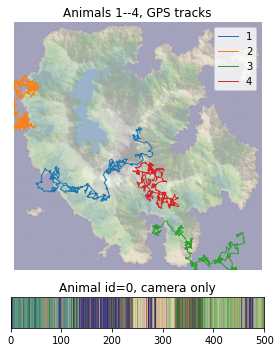

In [169]:
df = localization

fig,(ax,ax2) = plt.subplots(2,1, figsize=(4,5), gridspec_kw={'height_ratios':[4,.5]})
ax.imshow(map_image.transpose(1,0,2), alpha=.5)
w,h = map_image.shape[:2]
ax.set_xlim([0,w])
ax.set_ylim([0,h])

for i in range(1,5):
    ax.plot(df.loc[df.id==i,'x'].values, df.loc[df.id==i,'y'].values, lw=1, label=i)
ax.axis('off')
ax.legend()
ax.set_title('Animals 1--4, GPS tracks')

ax2.bar(np.arange(len(observations)), np.ones(len(observations)), color=observations, width=2)
ax2.set_xlim([0,len(observations)])
ax2.set_yticks([])
ax2.set_title('Animal id=0, camera only')

plt.tight_layout()
plt.show()

**Coding note.** Given an image `map_image`, we can treat it as a simple array, and get at the pixels with `map_image[i,j]`. I'll interpret this as x-coordinate i and y-coordinate j. However, the plotting routine `ax.imshow` interprets the first coordinate as y and the second as x, so I need to transpose the array before plotting it.

## 0. Empirical approximation of $X_0$

We'll start with a prior belief that the animal's location $X_0$ is uniformly distributed over the map.

The first step is to create a sample from this initial distribution. We'll store it as an $M\times 3$ array, one row per particle, with columns for $x$ coordinate, $y$ coordinate, and weight $w$. The prior distribution is uniform, so $w=1/M$. We'll call this matrix `δ0`.

Here's also a handy function to visualize the particles, use `show_particles`.

In [226]:
W,H = map_image.shape[:2]
M = num_particles = 2000

# Empirical representation of the distribution of X0
δ0 = np.column_stack([np.random.uniform(0,W-1,size=M), np.random.uniform(0,H-1,size=M), np.ones(M)/M])

In [227]:
def show_particles(particles, ax=None, s=1, c='red', alpha=.5):
    # Plot an array of particles, with size proportional to weight.
    # (Scale up the sizes by setting s larger.)
    if ax is None:
        fig,ax = plt.subplots(figsize=(2.5,2.5))
    ax.imshow(map_image.transpose(1,0,2), alpha=alpha, origin='lower')
    w,h = map_image.shape[:2]
    ax.set_xlim([0,w])
    ax.set_ylim([0,h])
    w = particles[:,2]
    ax.scatter(particles[:,0],particles[:,1], s=w/np.sum(w)*s, color=c)
    ax.axis('off')

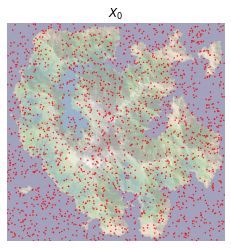

In [228]:
fig,ax = plt.subplots(figsize=(4,4))
show_particles(δ0, s=400, ax=ax)
ax.set_title('$X_0$')
plt.show()

## 1. Empirical approximation of $(X_0|y_0)$: updated weights

Let's first find the distribution of $(X_0|y_0)$, where $y_0$ is the first observation. Bayes's rule tells us the distribution:

$$
\operatorname{Pr}_{X_0}(x|y_0)=\text{const}\times \operatorname{Pr}_{X_0}(x)\Pr(y_0|X_0=x).
$$

We've seen the empirical approximation for this, in lecture notes on computational Bayes's rule. We take a sample from $X_0$, and we set the weight of sample point $p$ to be proportional to $\Pr(y_0|X_0=p)$. We already build ourselves a sample from $X_0$, in the previous section. We'll call our new weighted particles `π0`.

In [229]:
y0 = observations[0]
print(f"First observation: rgb = {y0}")

First observation: rgb = [0.27698774 0.4914071  0.42452084]


To apply Bayes's rule, we need a probability model for $Y_0$ given a particle's location. A reasonable guess is that $Y_0$ is a noisy version of the colour patch around the supposed location. Here's a handy utility to extract the average colour of a patch:

In [230]:
def patch(im, xy, size=3):
    s = (size-1) / 2
    nx,ny = np.meshgrid(np.arange(-s,s+1), np.arange(-s,s+1))
    nx,ny = np.stack([nx,ny], axis=0).reshape((2,-1))
    neighbourhood = np.row_stack([nx,ny])
    w,h = im.shape[:2]
    neighbours = neighbourhood + np.array(xy).reshape(-1,1)
    neighbours = nx,ny = np.round(neighbours).astype(int)
    nx,ny = neighbours[:, (nx>=0) & (nx<w) & (ny>=0) & (ny<h)]
    patch = im[nx,ny,:3]
    return np.mean(patch, axis=0)/255

In [231]:
loc = δ0[0,:2]
print(f"First particle is at {loc}")

col = patch(map_image, loc, size=3)
print(f"Map terrain around this particle: rgb = {col}")

First particle is at [324.54991998 595.25114696]
Map terrain around this particle: rgb = [0.28017429 0.28017429 0.48278867]


<div class="alert alert-warning">
    <div style="font-size: x-large">Task 1</div>

Implement a `pr(y,loc)` function to compute the probability of observing `y` if the true location is `loc`.

It's up to you to invent the probability model. A reasonable probability model is that the observed rgb values in `y` are independent Gaussian random variables,
with mean `patch(map_image, loc)`, and with a standard deviation that you should pick.
    If you want to be cleverer, consider a probability model based on closeness in HSL colour space.

</div>

In [ ]:
def pr(y, loc):
    # TODO: return a number

In [232]:
# Sanity check
y0 = observations[0]
loc = δ0[0,:2]
w = pr(y0, loc)
import numbers
assert isinstance(w, numbers.Number) and w>=0

Now we can set the weight of all the particles, and thereby obtain a sample of $(X_0|y_0)$.

In [233]:
y0 = observations[0]
w = np.array([pr(y0, (x,y)) for x,y,_ in δ0])
π0 = np.copy(δ0)
π0[:,2] = w / sum(w)

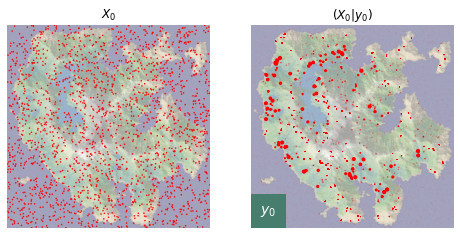

In [234]:
fig,(axδ,axπ) = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
show_particles(δ0, ax=axδ, s=600)
show_particles(π0, ax=axπ, s=600)
axπ.add_patch(matplotlib.patches.Rectangle((0,0),100,100,color=y0))
axπ.text(50,50,'$y_0$', c='white', ha='center', va='center', fontsize=14)
axδ.set_title('$X_0$')
axπ.set_title('$(X_0|y_0)$')
plt.show()

## 2. Empirical approximation of $(X_1|y_0)$: wandering particles

The next step is to find the distribution of the animal's location, after a timestep. 
Formally, we want to find the distribution of $(X_1|y_0)$.

We believe that the animal's location follows a Markov chain, in other words, that $X_1$ is generated from $X_0$
according to some random transition. It's easy to generate a sample of $X_1$ values: just take a sample of $X_0$ values, and apply a random transition to each of of the particles.
Likewise, if we have a *weighted* sample representing $(X_0|y_0)$, and we apply a random transition to each particle, and leave the weights unchanged, we'll get a weighted sample representing $(X_1|y_0)$.

We'll now compute a weighted sample for $(X_1|y_0)$, and call it `δ1`. To do this, we need a probability model for how the animal moves in each timestep.

<div class="alert alert-warning">
    <div style="font-size: x-large">Task 2</div>

Implement a `walk(loc)` function to simulate the animal's movement in one timestep.

A reasonable probability model is that the animal chooses a direction uniformly in the range $[0,2\pi)$, 
and then chooses a random distance, for example an Exponential random variable with mean 5.
And then truncate the position to ensure it lies on the map &mdash; otherwise the `patch` function won't work.

</div>

In [ ]:
def walk(loc):
    # TODO: return a new location

In [235]:
# Sanity check
loc = π0[0,:2]
loc2 = walk(loc)
assert len(loc2)==2 and isinstance(loc2[0], numbers.Number) and isinstance(loc2[1], numbers.Number)
assert loc2[0]>=0 and loc2[0]<=W-1 and loc2[1]>=0 and loc2[1]<=H-1

Now we can apply this movement to all the particles, and thereby obtain a sample of $(X_1|y_0)$.

In [236]:
δ1 = np.copy(π0)
for i in range(len(δ1)):
    δ1[i,:2] = walk(δ1[i,:2])

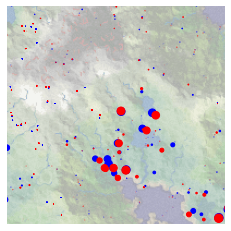

In [237]:
fig,ax = plt.subplots(figsize=(4,4))
show_particles(π0, ax=ax, s=4000, c='blue', alpha=.25)
show_particles(δ1, ax=ax, s=4000, c='red', alpha=.25)
ax.set_xlim([200,400])
ax.set_ylim([100,300])
plt.show()

## 3. Iterate

Now we can apply these two update steps iteratively, updating the sample based on successive observations.
The two steps of the iteration are

1. Given a weighted sample $(X_{n-1}|y_0,\dots,y_{n-1})$,
get a weighted sample of $(X_n|y_0,\dots,y_{n-1})$ by making each particle take a random step.


2. Given a weighted sample $(X_n|y_0,\dots,y_{n-1})$, get a weighted sample of
$(X_n|y_0,\dots,y_n)$ by **multiplying** the weight of each particle $p$ by $\Pr(y_n|X_n=p)$ and then rescaling weights.


(Step 2 is a generalization of the Bayes update rule. The simple Bayes update rule is for when we start with a uniformly-weighted sample from the peior, and this version applies when we start with a weighted sample from the prior.)

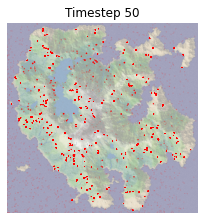

In [238]:
particles = np.copy(π0)

for n,obs in enumerate(observations[:50]):
    # Compute δ, the locations after a movement step
    for i in range(num_particles):
        particles[i,:2] = walk(particles[i,:2])
    # Compute π, the posterior after observing y
    w = np.array([pr(obs, (px,py)) for px,py,_ in particles])
    particles[:,2] = w / sum(w)

    # Plot the current particles
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    show_particles(particles, ax, s=20)
    ax.set_title(f"Timestep {n+1}")
    plt.show()
    clear_output(wait=True)

When you run this, you will likely find that the output is completely useless! The problem is numerical
instability. We're only using 2000 samples, and many of these samples get assigned a weight that is almost zero, 
so we end up with a tiny sample.

<div class="alert alert-warning">
    <div style="font-size: x-large">Task 3</div>

Plot a histogram of particle weights, after 0, 1, 5, 50, and 100 timesteps.

</div>

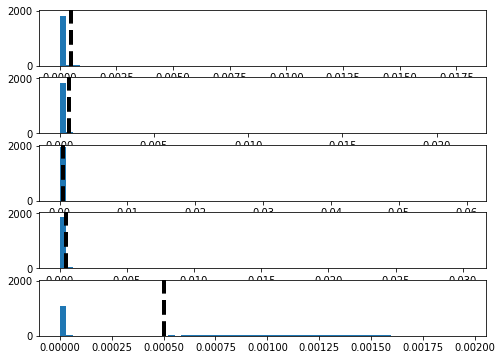

In [240]:
fig,axes = plt.subplots(5,1, figsize=(8,6), sharey=True)
for n,ax in zip([0,1,5,50,100],axes):
    # TODO: let w be the appropriate weights
    ax.hist(w, bins=60)
    ax.axvline(x=1/len(particles), color='black', linewidth=4, linestyle='dashed')
plt.show()

## 4. Particle hygiene

Empirical approximations work better when the weights are reasonably well distributed. There's nothing stopping us from modifying our set of particles to balance out the weights, as long as we don't mess up the empirical approximation. For example, we could take a particle with excessively high weight, and split it into two particles each with half the weight. After the next `walk` step, those two particles will diverge, and so we'll hopefully get a good spread.

<div class="alert alert-warning">
    <div style="font-size: x-large">Task 4</div>

Implement a function `prune_spawn(particles)`. This should delete the lowest-weighted 20% of the particles.
Then it should take the highest-weighted 20% of the particles, and split them in two. In other words 
it should create a duplicate at the same location, and give both the original and the duplicate half the weight. The two versions will diverge in the future, as they take different steps.

Apply this function every iteration, and show an animation of the result.

After processing 100 observations, you should see something like the picture in the cell below.
</div>

In [241]:
def prune_spawn(particles):
    # TODO: prune and spawn particles

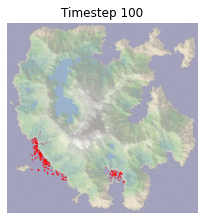

In [242]:
particles = np.copy(π0)

for n,obs in enumerate(observations[:100]):
    # Compute δ, the locations after a movement step
    for i in range(num_particles):
        particles[i,:2] = walk(particles[i,:2])
    # Compute π, the posterior after observing y
    w = np.array([pr(obs, (px,py)) for px,py,_ in particles])
    particles[:,2] = w / sum(w)
    # Prune/spawn
    prune_spawn(particles)

    # Plot the current particles
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    show_particles(particles, ax, s=20)
    ax.set_title(f"Timestep {n+1}")
    plt.show()
    clear_output(wait=True)